In [1]:
#!wget https://zenodo.org/records/4736111/files/LabPicsChemistry.zip

In [2]:
#!unzip LabPicsChemistry.zip

In [3]:
#!pip install -q --upgrade  torch_snippets

In [4]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from tqdm.notebook import tqdm
import pandas as pd
import glob

In [5]:
from torchvision import transforms, models, datasets
from torch.utils.data import TensorDataset, DataLoader

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.utils.data
import torchvision.models.segmentation
import torch
from torch_snippets import *

In [7]:
trainDir=os.path.join("LabPics Chemistry","Train")
testDir=os.path.join("LabPics Chemistry","Test")
imageSize=[600,600]

imgs=[os.path.join(trainDir,pth ) for pth in os.listdir(trainDir) if len(os.listdir(os.path.join(trainDir,pth,"Vessels" )))>0 ]
print(len(imgs))

4983

(-0.5, 599.5, 599.5, -0.5)

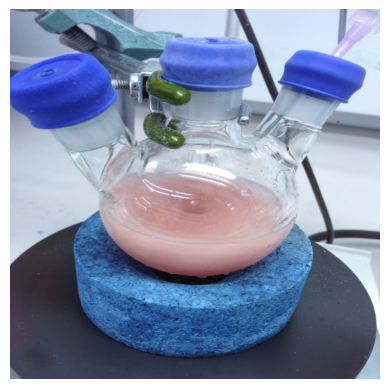

In [8]:
idx=10
img = cv2.imread(os.path.join(imgs[idx], "Image.jpg"))
img = cv2.resize(img, imageSize, cv2.INTER_LINEAR)
plt.imshow(img)
plt.axis('off')

In [9]:
maskDir=os.path.join(imgs[idx], "Vessels")
masks=[]
for mskName in os.listdir(maskDir):
            vesMask = (cv2.imread(os.path.join(maskDir,mskName), 0) > 0).astype(np.uint8)  # Lire le masque de l'instance de vesse
            vesMask=cv2.resize(vesMask,imageSize,cv2.INTER_NEAREST)
            masks.append(vesMask)# obtenir les coordonnées de la boîte englobante pour chaque masque
num_objs = len(masks)
print(num_objs)

1

(-0.5, 599.5, 599.5, -0.5)

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

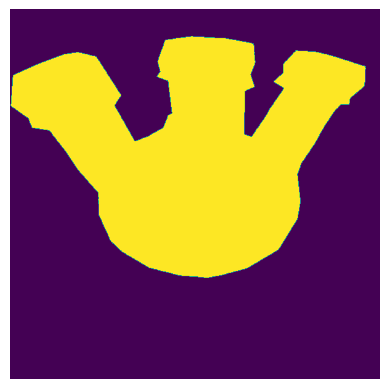

In [10]:

plt.imshow(masks[0])
plt.axis('off')

In [11]:
boxes = np.zeros([num_objs,4])
for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])

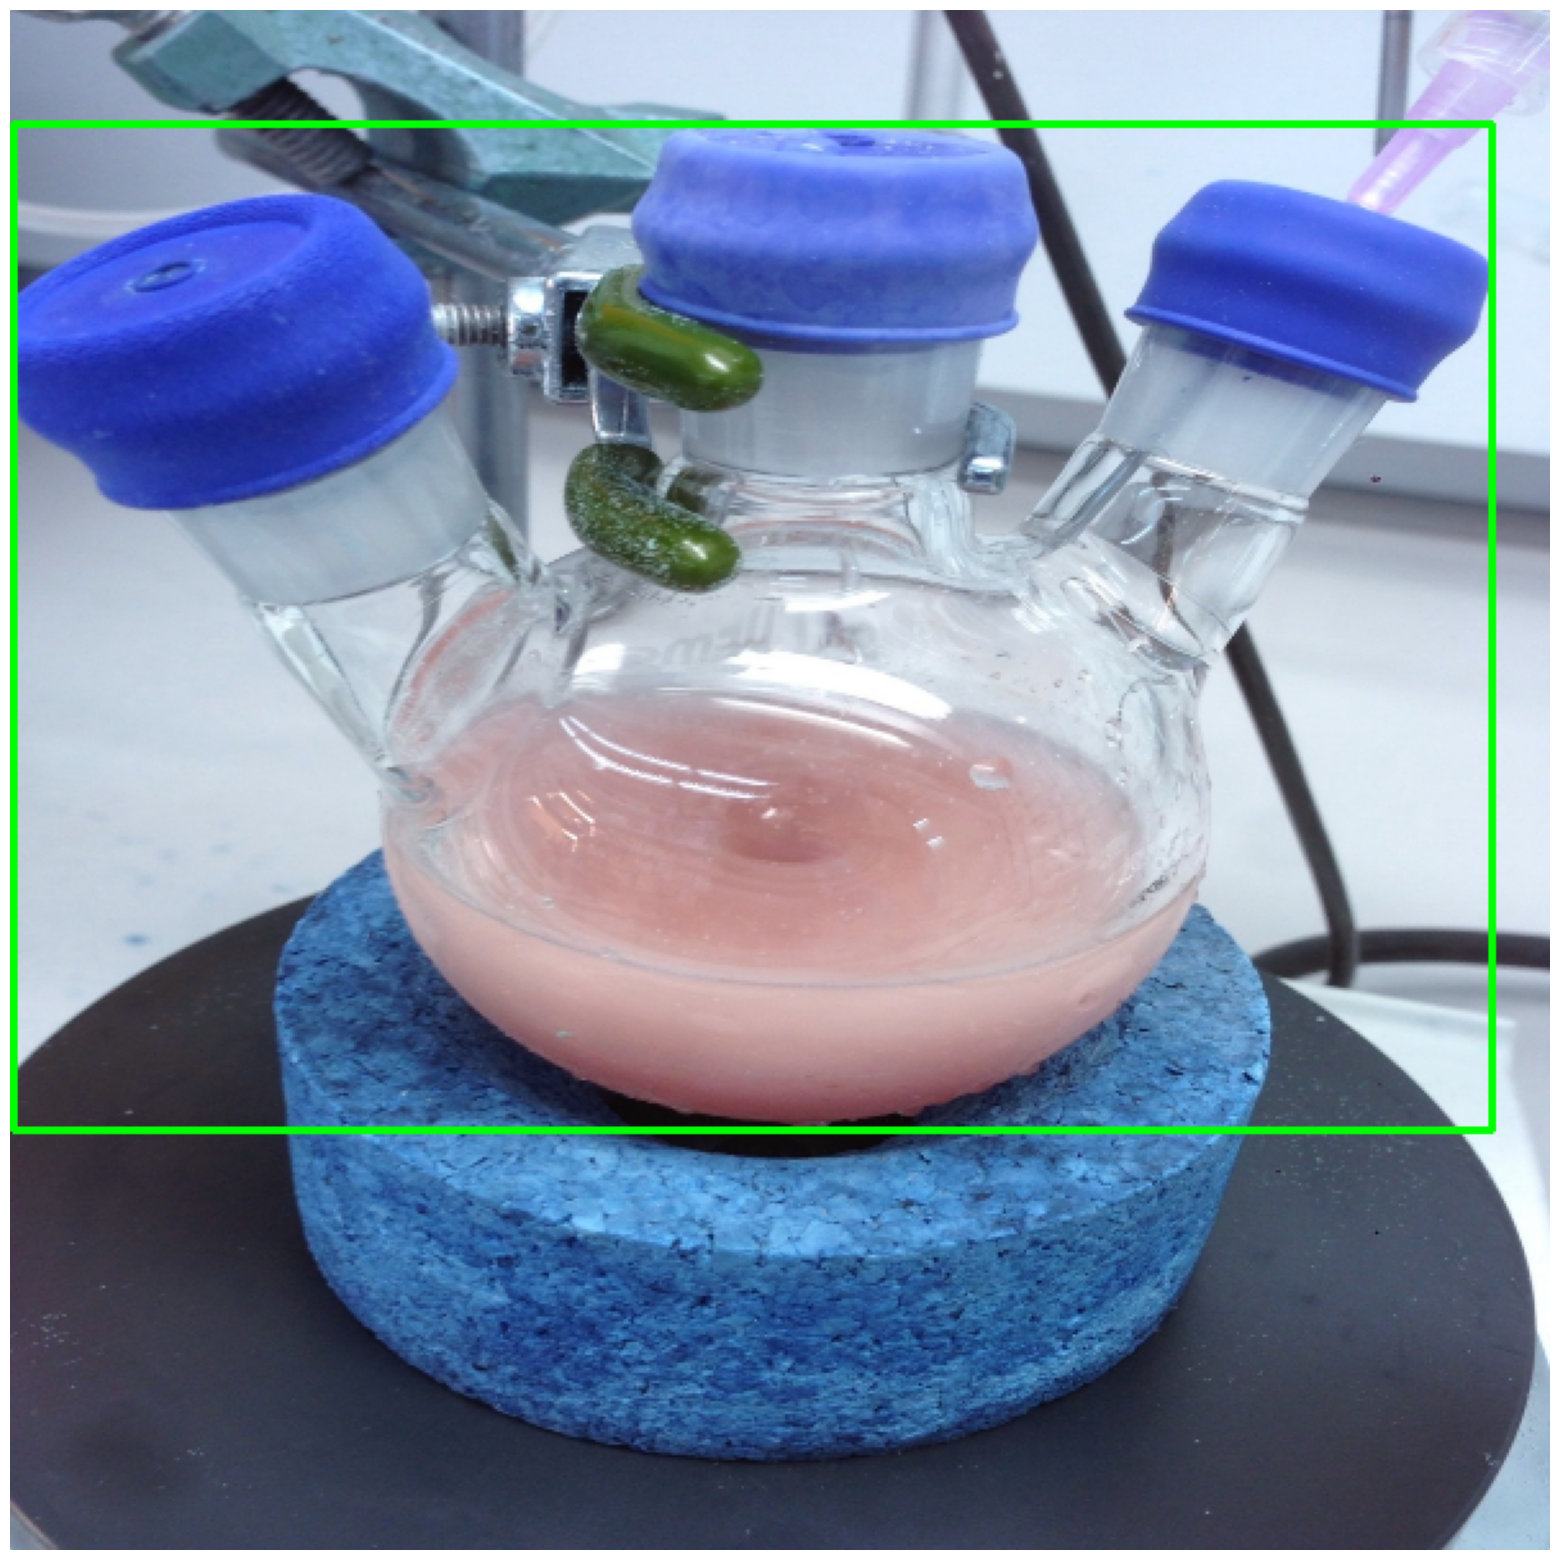

In [12]:
show(img,bbs=boxes)

In [13]:
class ChemistryImages(Dataset):
    def __init__(self, image_folder):
        self.root = image_folder

        self.imageSize=[600,600]
        self.image_folder=image_folder
        self.unique_images=[os.path.join(image_folder,pth ) for pth in os.listdir(image_folder) if len(os.listdir(os.path.join(image_folder,pth,"Vessels" )))>0 ]


    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_path= self.unique_images[ix]

        img = cv2.imread(os.path.join(image_path, "Image.jpg"))
        img = cv2.resize(img, self.imageSize, cv2.INTER_LINEAR)

        maskDir=os.path.join(image_path, "Vessels")
        masks=[]
        for mskName in os.listdir(maskDir):
            vesMask =  (cv2.imread(os.path.join(maskDir,mskName), 0) > 0).astype(np.uint8)
            vesMask=cv2.resize(vesMask,self.imageSize,cv2.INTER_NEAREST)
            masks.append(vesMask)
        num_objs = len(masks)
        assert(num_objs>0)
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img/255, dtype=torch.float32).permute(2,0,1)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
        data["masks"] = masks

        return img, data

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_dataset = ChemistryImages(trainDir)


In [16]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<ipython-input-13-6661fc3705f9>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


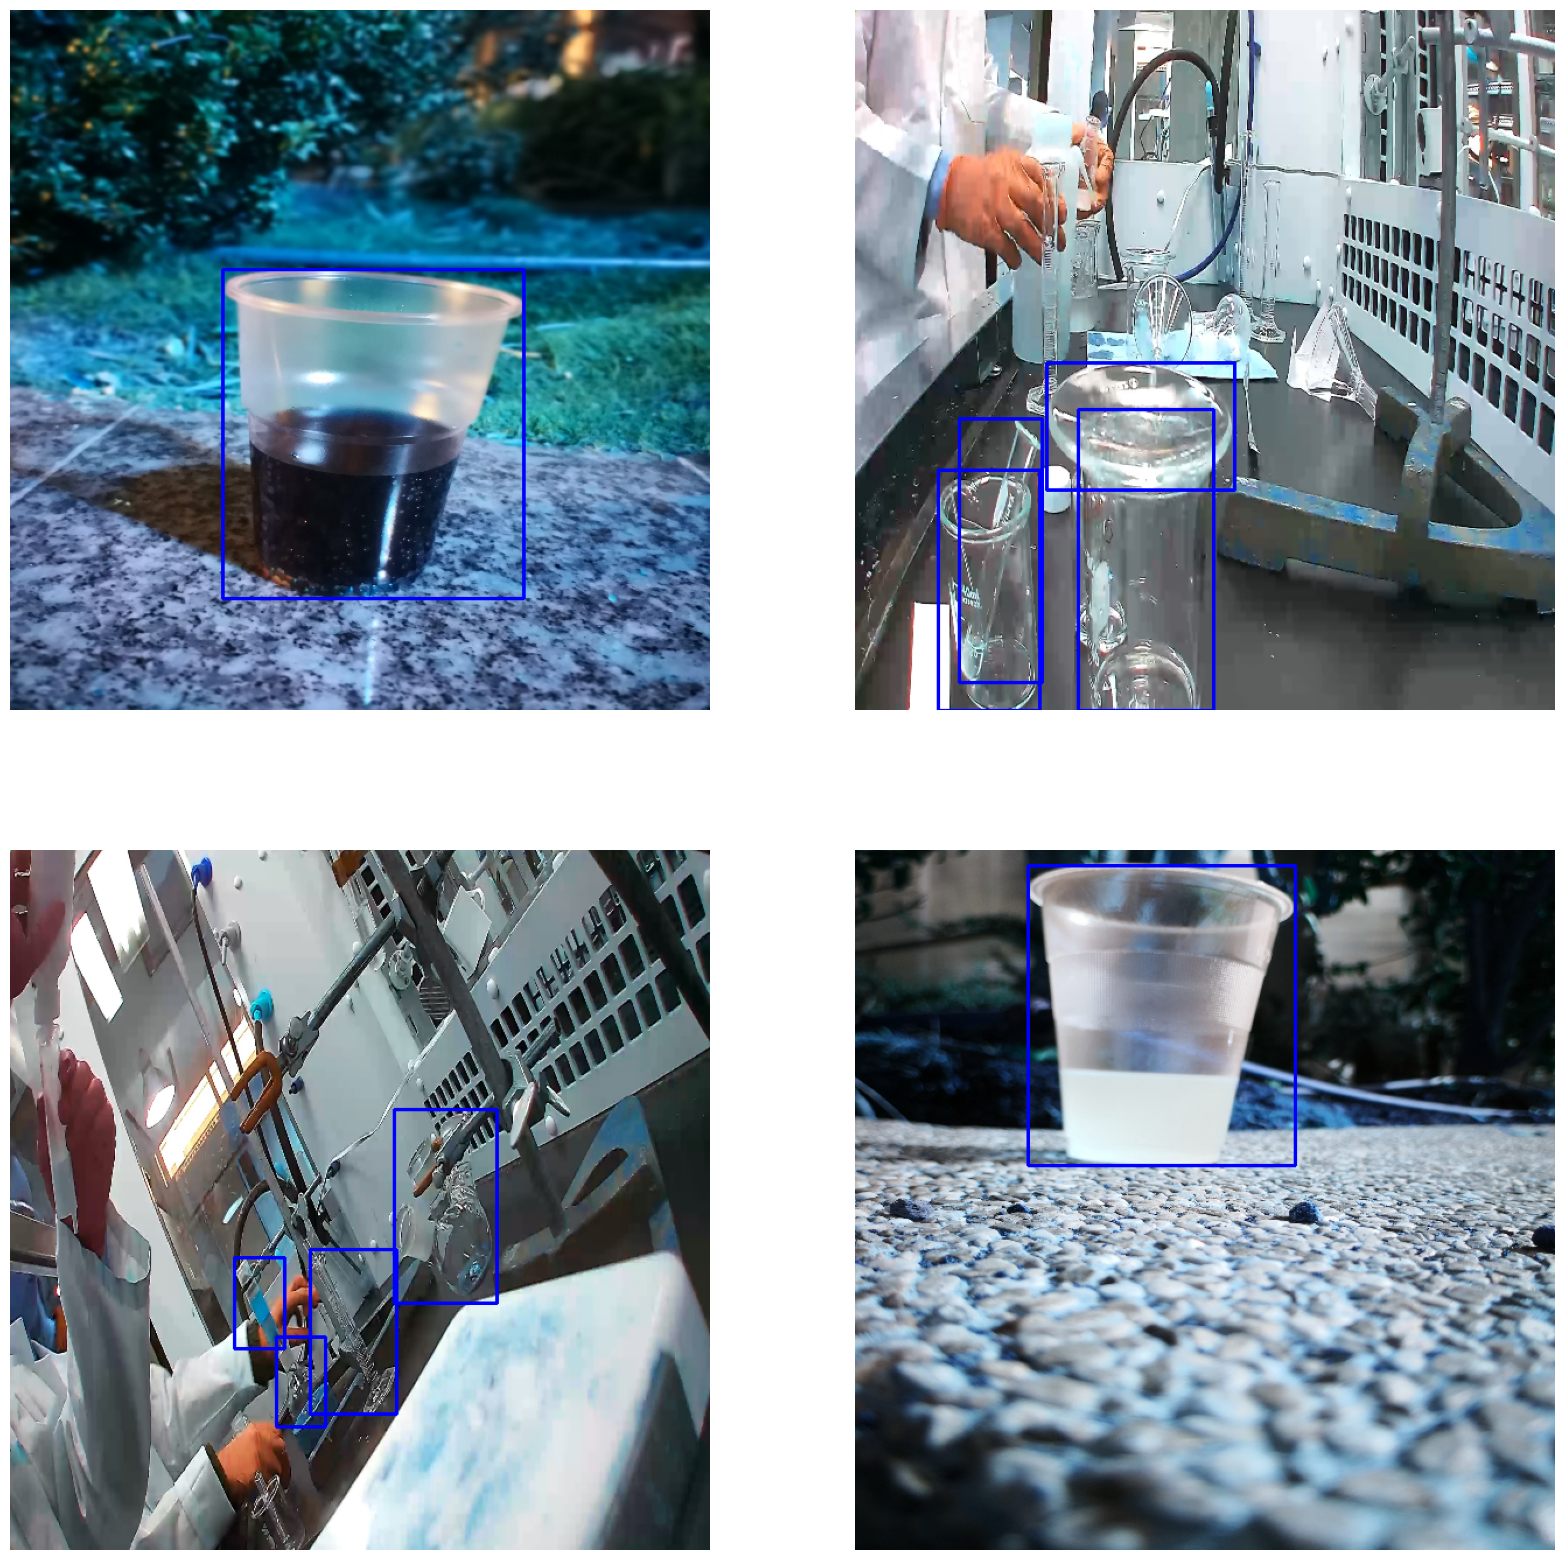

In [18]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)

    plt.axis('off')
    plt.imshow(sample)

#Construction du modèle

In [19]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # charger un modèle de segmentation d'instance pré-entraîné sur COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features # obtenir le nombre de caractéristiques d'entrée pour le classificateur
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # remplacer la tête pré-entraînée par une nouvelle tête
model.to(device)# déplacer le modèle vers le bon appareil

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Formation du modèle

In [20]:
! pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_zsh0zch
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_zsh0zch
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [21]:
! git clone https://github.com/pytorch/vision.git
! cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [22]:
from engine import train_one_epoch, evaluate
import utils

In [23]:
num_epochs = 3

for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
     train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
#     # update the learning rate
     lr_scheduler.step()


Epoch: [0]  [   0/1246]  eta: 1:00:26  lr: 0.000000  loss: 1.8739 (1.8739)  loss_classifier: 0.7228 (0.7228)  loss_box_reg: 0.2796 (0.2796)  loss_mask: 0.8016 (0.8016)  loss_objectness: 0.0624 (0.0624)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 2.9105  data: 0.9559  max mem: 3069
Epoch: [0]  [  10/1246]  eta: 0:51:42  lr: 0.000000  loss: 1.8739 (1.8676)  loss_classifier: 0.7228 (0.7200)  loss_box_reg: 0.2443 (0.2490)  loss_mask: 0.8372 (0.8582)  loss_objectness: 0.0169 (0.0240)  loss_rpn_box_reg: 0.0096 (0.0164)  time: 2.5102  data: 1.5382  max mem: 3404
Epoch: [0]  [  20/1246]  eta: 0:41:20  lr: 0.000000  loss: 1.8884 (1.9157)  loss_classifier: 0.7136 (0.7114)  loss_box_reg: 0.2443 (0.2689)  loss_mask: 0.8372 (0.8939)  loss_objectness: 0.0154 (0.0228)  loss_rpn_box_reg: 0.0096 (0.0187)  time: 1.9787  data: 1.1487  max mem: 3406
Epoch: [0]  [  30/1246]  eta: 0:37:40  lr: 0.000000  loss: 1.7658 (1.8488)  loss_classifier: 0.7076 (0.7068)  loss_box_reg: 0.2762 (0.2752)  loss_mask: 0.7549 (

KeyError: 'image_id'

In [ ]:
model.eval()

In [25]:
imgs=[os.path.join(testDir,pth ) for pth in os.listdir(testDir) if len(os.listdir(os.path.join(testDir,pth,"Vessels" )))>0 ]
print(len(imgs))

1355

(-0.5, 599.5, 599.5, -0.5)

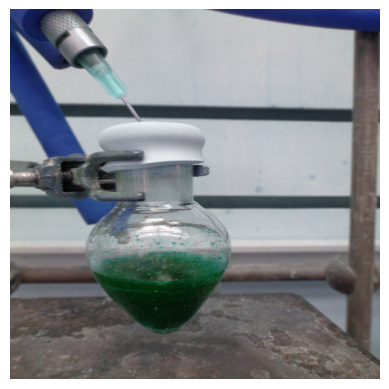

In [55]:
imgPath=imgs[10]
image=cv2.imread(os.path.join(imgPath, "Image.jpg"))
image = cv2.resize(image, imageSize, cv2.INTER_LINEAR)
plt.imshow(image)
plt.axis('off')

In [56]:
images = torch.as_tensor(image/255, dtype=torch.float32).unsqueeze(0).permute(0,3,1,2)

images = list(image.to(device) for image in images)

In [57]:
with torch.no_grad():
    pred = model(images)

In [40]:
len(pred)

1

In [41]:
pred[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [42]:
pred[0]['boxes']

tensor([[112.2167, 170.4471, 356.2012, 533.5117],
        [ 33.5335,   2.1389, 215.5828, 195.5825],
        [ 46.9112,  86.0545, 432.8541, 565.3875],
        [  0.0000, 230.7421, 199.6719, 317.2615],
        [ 65.9810, 232.7956, 339.8228, 433.8175],
        [ 49.1725,   0.0000, 176.4277, 133.1842],
        [ 11.6129, 186.0974, 291.8365, 349.3499],
        [  1.0574,   8.1100, 238.1154, 335.3251],
        [531.5388,  10.2009, 600.0000, 571.4453],
        [ 13.1416,   2.9231, 368.8866, 414.4274],
        [512.8781, 393.7897, 564.0873, 465.8574],
        [ 77.3451,  61.3196, 216.1933, 185.0364],
        [ 62.9894,  33.3576, 211.7963, 423.1431]], device='cuda:0')

In [58]:
boxes = pred[0]['boxes'].data.cpu().numpy()
scores = pred[0]['scores'].data.cpu().numpy()
labels = pred[0]['labels'].data.cpu().numpy()
masks= pred[0]['masks'].data.cpu().numpy()

In [51]:
detection_threshold = 0.70

In [52]:
masks.shape

(13, 1, 600, 600)

In [59]:
labels = labels[scores >= detection_threshold]
boxes = boxes[scores >= detection_threshold].astype(np.int32)
masks = masks [scores >= detection_threshold]
scores = scores[scores >= detection_threshold]


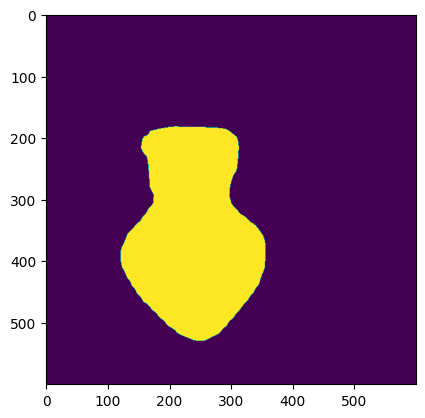

In [65]:
plt.imshow((masks[i,0]>0.5))

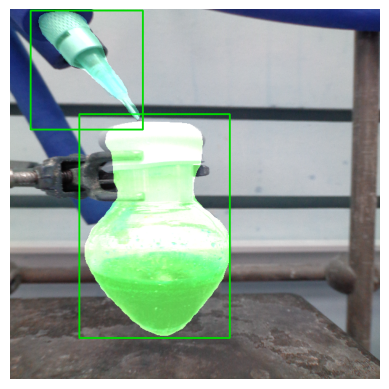

In [67]:
for i,box in enumerate(boxes):

        redImg = np.zeros(image.shape, image.dtype)
        redImg[:,:] = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        redMask = cv2.bitwise_and(redImg, redImg, mask=(masks[i,0]>0.5).astype('uint8'))
        cv2.addWeighted(redMask, 1, image, 1, 0, image)
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)

plt.axis('off')
plt.imshow(image)